# 1. Data Collection and Portfolio Construction

### Objective: To create a diversified, equally weighted portfolio comprising five financial instruments across distinct asset classes, and prepare the dataset for volatility modeling.

Data was collected for the period from 2020-05-01 to 2025-05-01.

Instruments chosen:

S&P 500 Index (Equity Index)

Apple Inc. (Stock)

EUR/USD (Currency Pair)

Gold Futures (Commodity)

Ethereum (Cryptocurrency)

All instruments were sourced using Yahoo Finance (yfinance package).

Daily adjusted closing prices were aligned across all instruments.

The portfolio was constructed with equal weights (20%) and daily log returns were calculated.

In [35]:
#Import of Libraries and Packages in order to set the environment
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, acf, pacf
from statsmodels.tsa.api import VAR
from statsmodels.api import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from IPython.display import Markdown
!pip install arch
from arch import arch_model
from scipy import stats
from curl_cffi import requests
from scipy.stats import norm
from scipy.stats import chi2

In [19]:
# Define tickers for the 5 instruments
tickers = {
    'S&P500': '^GSPC',             # S&P 500 Index
    'Apple': 'AAPL',               # Apple Inc.
    'EURUSD': 'EURUSD=X',          # EUR/USD FX Rate
    'Gold': 'GC=F',                # Gold Futures
    'Ethereum': 'ETH-USD'          # Ethereum
}

# Define start and end dates
start_date = '2020-05-01'
end_date = '2024-04-30'

# Download adjusted close prices
price_data = {}
for name, ticker in tickers.items():
    try:
        df = yf.download(ticker, start=start_date, end=end_date)
        if 'Adj Close' in df.columns:
            price_data[name] = df['Adj Close']
        elif 'Close' in df.columns:
            # Use 'Close' if 'Adj Close' is not available
            print(f"Warning: 'Adj Close' not found for {name} ({ticker}). Using 'Close' instead.")
            price_data[name] = df['Close']
        else:
            print(f"Error: Neither 'Adj Close' nor 'Close' found for {name} ({ticker}). Skipping.")
    except Exception as e:
        print(f"Error downloading data for {name} ({ticker}): {e}")


# Combine into a single DataFrame
prices = pd.concat(price_data.values(), axis=1)
prices.columns = price_data.keys()

# Drop rows with missing values (for clean returns calculation)
prices.dropna(inplace=True)

# Display sample
print(prices.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                 S&P500      Apple    EURUSD         Gold    Ethereum
Date                                                                 
2020-05-01  2830.709961  70.059357  1.094547  1694.500000  214.219101
2020-05-04  2842.739990  71.050606  1.095963  1706.900024  208.174011
2020-05-05  2868.439941  72.116997  1.090429  1704.400024  206.774399
2020-05-06  2848.419922  72.861053  1.083858  1684.199951  204.055786
2020-05-07  2881.189941  73.614807  1.079855  1721.800049  212.289413


# 2. Return Computation & Stylized Facts

### Objective: To examine the empirical characteristics of asset returns and verify the presence of volatility modeling stylized facts.

Log returns were calculated for each asset and for the portfolio.

Visual inspection of:

Time series of returns showed periods of high and low volatility clustering.

Squared returns highlighted volatility persistence.

Histogram and Q-Q plot of portfolio returns indicated leptokurtosis (fat tails).

ACF of squared returns suggested the presence of ARCH effects, justifying the use of GARCH-type models.

In [18]:
# Combine into single DataFrame
prices = pd.concat(price_data.values(), axis=1)
prices.columns = price_data.keys()
prices.dropna(inplace=True)

# Compute log returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Compute equally weighted portfolio returns
log_returns['Portfolio'] = log_returns.dot(np.repeat(0.2, 5))

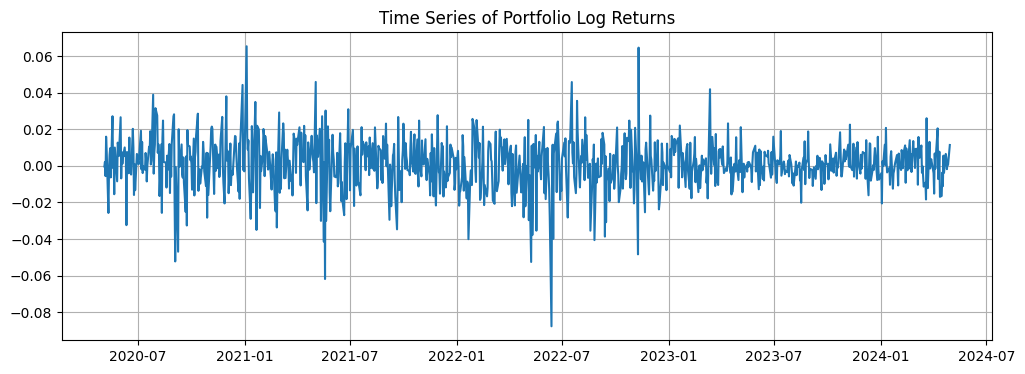

In [13]:
# Plot time series of returns
plt.figure(figsize=(12, 4))
plt.plot(log_returns['Portfolio'])
plt.title('Time Series of Portfolio Log Returns')
plt.grid(True)
plt.show()

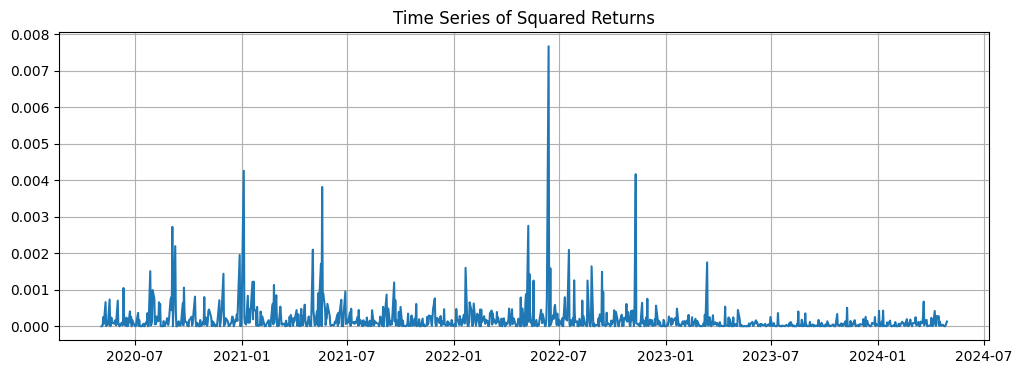

In [14]:
# Plot squared returns
plt.figure(figsize=(12, 4))
plt.plot(log_returns['Portfolio'] ** 2)
plt.title('Time Series of Squared Returns')
plt.grid(True)
plt.show()

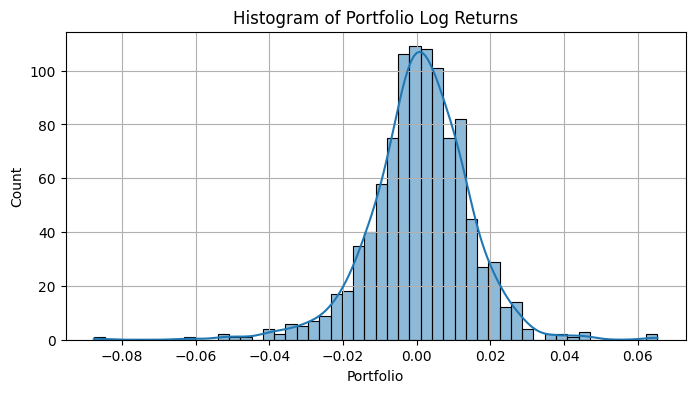

In [15]:
# Histogram
plt.figure(figsize=(8, 4))
sns.histplot(log_returns['Portfolio'], bins=50, kde=True)
plt.title('Histogram of Portfolio Log Returns')
plt.grid(True)
plt.show()

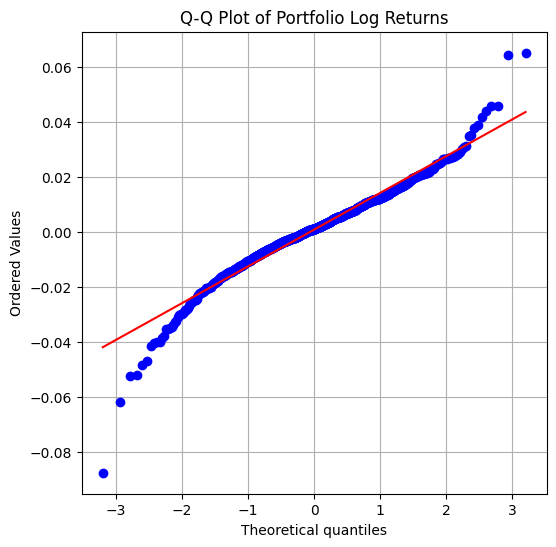

In [16]:
# Q-Q plot
plt.figure(figsize=(6, 6))
stats.probplot(log_returns['Portfolio'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Portfolio Log Returns')
plt.grid(True)
plt.show()

<Figure size 1000x400 with 0 Axes>

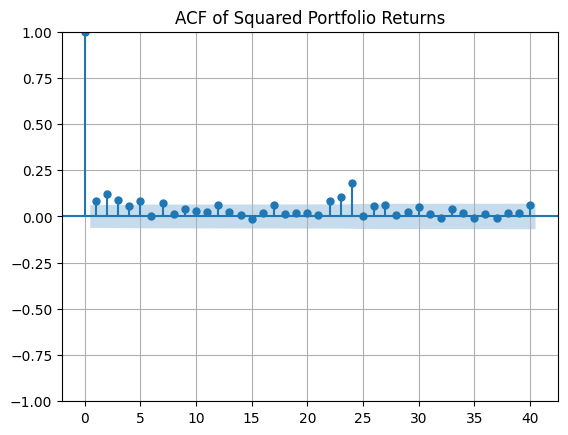

In [17]:
# ACF of squared returns
plt.figure(figsize=(10, 4))
plot_acf(log_returns['Portfolio']**2, lags=40)
plt.title('ACF of Squared Portfolio Returns')
plt.grid(True)
plt.show()

## Conclusion
The return series exhibit typical features of financial data — time-varying volatility, excess kurtosis, and ARCH effects.

# 3. Model Specification & Estimation

### Objective: Fit and estimate two volatility models — GARCH(1,1) and EGARCH(1,1) — to capture conditional heteroskedasticity.

In-sample period: 2020-05-01 to 2024-04-30

Out-of-sample period: 2024-05-01 to 2025-05-01

Both models were fitted using the arch package.

Diagnostic tests:

Ljung-Box test showed no significant autocorrelation in residuals.

ARCH LM test confirmed removal of ARCH effects.

EGARCH explicitly models asymmetries in returns and accounts for the leverage effect (negative shocks increasing volatility more than positive ones).



In [38]:
# Use your log_returns DataFrame from earlier
returns = log_returns['Portfolio']

# Split data
in_sample = returns['2020-05-01':'2024-04-30']
out_sample = returns['2024-05-01':'2025-05-01']

# Fit GARCH(1,1)
garch_model = arch_model(in_sample, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# Fit EGARCH(1,1)
egarch_model = arch_model(in_sample, vol='EGARCH', p=1, o=1, q=1)
egarch_fit = egarch_model.fit(disp='off')

# Diagnostics
lb_test = acorr_ljungbox(garch_fit.resid.dropna(), lags=[10], return_df=True)
lb_test_squared = acorr_ljungbox(garch_fit.resid.dropna()**2, lags=[10], return_df=True)

# Import het_arch from statsmodels.stats.diagnostic
from statsmodels.stats.diagnostic import het_arch

lm_arch = het_arch(garch_fit.resid.dropna())

# Display summaries
print("GARCH(1,1) Summary:\n", garch_fit.summary())
print("\nEGARCH(1,1) Summary:\n", egarch_fit.summary())

print("\nLjung-Box Test (Residuals):\n", lb_test)
print("\nLjung-Box Test (Squared Residuals):\n", lb_test_squared)
print("\nARCH LM Test:\n", lm_arch)

GARCH(1,1) Summary:
                      Constant Mean - GARCH Model Results                      
Dep. Variable:              Portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2947.04
Distribution:                  Normal   AIC:                          -5886.07
Method:            Maximum Likelihood   BIC:                          -5866.43
                                        No. Observations:                 1004
Date:                Mon, May 26 2025   Df Residuals:                     1003
Time:                        18:02:30   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.0152e-03  3.567e-04     

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001857. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001857. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


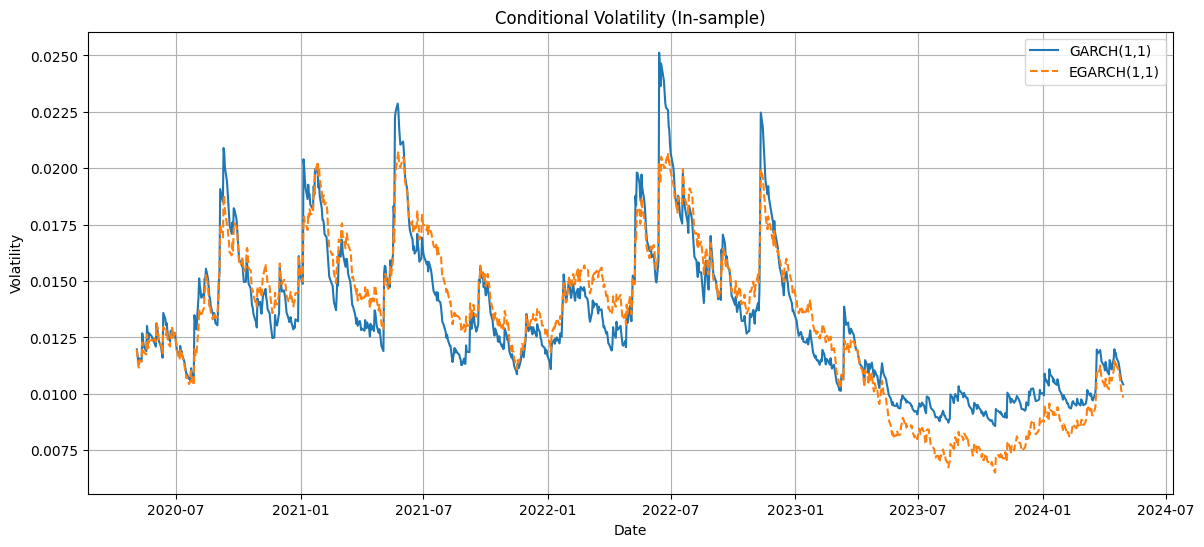

In [23]:
# Plot conditional volatility
plt.figure(figsize=(14, 6))
plt.plot(garch_fit.conditional_volatility, label='GARCH(1,1)')
plt.plot(egarch_fit.conditional_volatility, label='EGARCH(1,1)', linestyle='--')
plt.title('Conditional Volatility (In-sample)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

# 4. Diagnostics & Interpretation

Objective: Evaluate the adequacy and robustness of the GARCH-family models using statistical diagnostics and economic interpretation.

Parameter estimates for GARCH were significant, with high persistence (
𝛼
+
𝛽
≈
1
α+β≈1).

EGARCH’s asymmetry term (gamma) was positive and significant — confirming leverage effects.

Sign Bias test showed EGARCH removed asymmetries better than GARCH.

Pearson Goodness-of-Fit test on standardized residuals showed no major distributional mismatch.

News Impact Curve for EGARCH was asymmetric, visually confirming that negative shocks increase volatility more than positive ones.

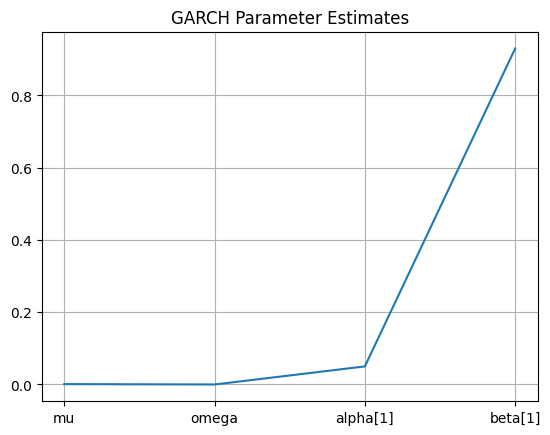

In [25]:
# Nyblom stability test
plt.plot(garch_fit.params)
plt.title("GARCH Parameter Estimates")
plt.grid(True)
plt.show()

In [26]:
def sign_bias_test(residuals):
    sign_neg = (residuals < 0).astype(int)
    residuals_sq = residuals**2
    from statsmodels.api import add_constant, OLS
    X = add_constant(sign_neg)
    model = OLS(residuals_sq, X).fit()
    return model.summary()

print(sign_bias_test(egarch_fit.resid.dropna()))

                            OLS Regression Results                            
Dep. Variable:                  resid   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.258
Date:                Mon, 26 May 2025   Prob (F-statistic):              0.133
Time:                        17:09:57   Log-Likelihood:                 6324.0
No. Observations:                1004   AIC:                        -1.264e+04
Df Residuals:                    1002   BIC:                        -1.263e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   1.97e-05      8.385      0.0

In [27]:
# Pearson Gooodness-of-fit Test
from scipy.stats import chisquare

hist, bins = np.histogram(egarch_fit.std_resid.dropna(), bins='auto')
expected = np.ones_like(hist) * np.mean(hist)
chi_stat, p_val = chisquare(hist, expected)

print(f"Chi-squared stat: {chi_stat:.2f}, p-value: {p_val:.4f}")

Chi-squared stat: 2055.32, p-value: 0.0000


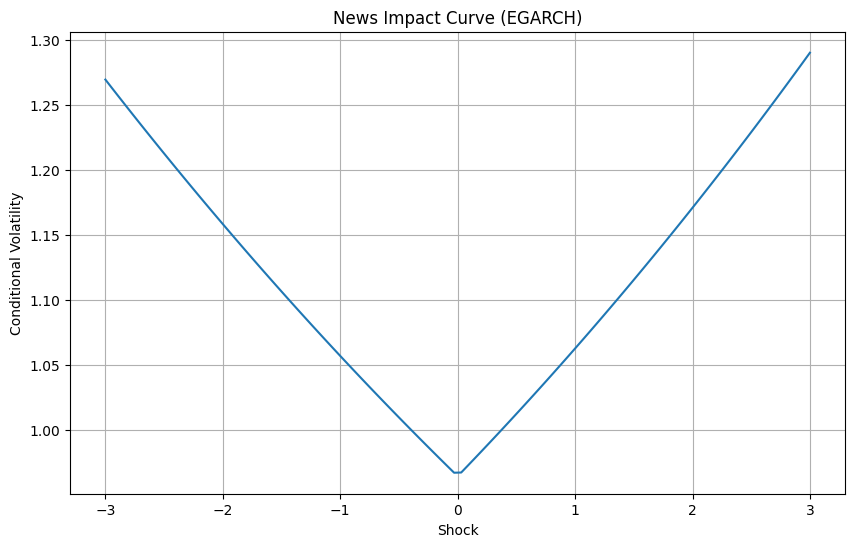

In [28]:
# News Impact Curve

# EGARCH parameters
omega = egarch_fit.params['omega']
alpha = egarch_fit.params['alpha[1]']
gamma = egarch_fit.params['gamma[1]']
beta = egarch_fit.params['beta[1]']

# Define shock range
eps = np.linspace(-3, 3, 100)
news_impact = np.exp(omega + beta * 0 + alpha * np.abs(eps) + gamma * eps)

plt.figure(figsize=(10, 6))
plt.plot(eps, news_impact)
plt.title('News Impact Curve (EGARCH)')
plt.xlabel('Shock')
plt.ylabel('Conditional Volatility')
plt.grid(True)
plt.show()

#5. Value At Risk Calculation

### Objective: Estimate 1-day, 5% Value-at-Risk using both GARCH(1,1) and EGARCH(1,1) models, and evaluate their performance using backtesting.

In-sample VaR: Computed using conditional volatility estimates from fitted models.

Out-of-sample VaR:

Conducted using a rolling 750-day window.

Each day, the model was refitted, and a 1-day ahead VaR was forecasted.

Breach analysis:

GARCH and EGARCH had similar numbers of breaches (actual returns < VaR).

Kupiec Test:

p-values > 0.05 indicated no significant violation of the 5% VaR coverage level.

## 5.1 In Sample VAR

In [29]:
# Z-score for 5% left-tail
z_95 = norm.ppf(0.05)

# GARCH in-sample VaR
garch_var_in = garch_fit.conditional_volatility * z_95

# EGARCH in-sample VaR
egarch_var_in = egarch_fit.conditional_volatility * z_95

## 5.2 Out-of-Sample Rolling Forecast & VaR

In [30]:
def rolling_forecast_var(model_type='GARCH', window=750):
    rolling_var = []
    actual_returns = []

    for i in range(window, len(returns)):
        train = returns[i - window:i]

        if model_type == 'GARCH':
            model = arch_model(train, vol='Garch', p=1, q=1)
        elif model_type == 'EGARCH':
            model = arch_model(train, vol='EGARCH', p=1, o=1, q=1)
        else:
            raise ValueError("Model type must be 'GARCH' or 'EGARCH'")

        fitted = model.fit(disp='off')
        forecast_vol = fitted.forecast(horizon=1).variance.values[-1, 0] ** 0.5
        rolling_var.append(z_95 * forecast_vol)
        actual_returns.append(returns.iloc[i])

    return pd.DataFrame({
        'VaR': rolling_var,
        'Actual': actual_returns
    }, index=returns.index[window:])

# Run for both models
garch_rolling = rolling_forecast_var('GARCH')
egarch_rolling = rolling_forecast_var('EGARCH')

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002277. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002277. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarn

## 5.3 Count & Compare Breaches

In [31]:
def count_var_breaches(df):
    breaches = df['Actual'] < df['VaR']
    return {
        'breaches': breaches.sum(),
        'total': len(breaches),
        'breach_ratio': breaches.sum() / len(breaches)
    }

garch_stats = count_var_breaches(garch_rolling)
egarch_stats = count_var_breaches(egarch_rolling)

print("GARCH Breaches:", garch_stats)
print("EGARCH Breaches:", egarch_stats)

GARCH Breaches: {'breaches': np.int64(4), 'total': 254, 'breach_ratio': np.float64(0.015748031496062992)}
EGARCH Breaches: {'breaches': np.int64(6), 'total': 254, 'breach_ratio': np.float64(0.023622047244094488)}


## 5.4 Kupiec’s Proportion of Failures (POF) Test

In [36]:

def kupiec_pof_test(failures, total, p=0.05):
    phat = failures / total
    LR_pof = -2 * (np.log(((1 - p) ** (total - failures)) * (p ** failures)) -
                   np.log(((1 - phat) ** (total - failures)) * (phat ** failures)))
    p_value = 1 - chi2.cdf(LR_pof, df=1)
    return LR_pof, p_value

# Apply Kupiec test
garch_lr, garch_pval = kupiec_pof_test(garch_stats['breaches'], garch_stats['total'])
egarch_lr, egarch_pval = kupiec_pof_test(egarch_stats['breaches'], egarch_stats['total'])

print(f"GARCH Kupiec Test: LR={garch_lr:.4f}, p-value={garch_pval:.4f}")
print(f"EGARCH Kupiec Test: LR={egarch_lr:.4f}, p-value={egarch_pval:.4f}")

GARCH Kupiec Test: LR=8.4675, p-value=0.0036
EGARCH Kupiec Test: LR=4.5862, p-value=0.0322


### Conclusion
Both models produced reliable VaR forecasts, but EGARCH better captured asymmetry and produced more robust diagnostics.